# Customer Segmentation and Product Analysis for a NYC Fashion Wholesaler

Melanie Uhde

In [1]:
# loading required packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pylab as pl
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import cluster, tree, decomposition
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from matplotlib import cm

%load_ext autoreload
%autoreload 2

## 1. Import and clean dataset

- the pre-processing file includes functions to:

    - desparsify the dataset
    - convert datetime columns and create columns for year and month of order
    - convert all strings to lower cases
    - drop columns that contain no information due to NAs
    - merge categories to reduce number of different categories of selected columns
    - extract categories, colors, materials, and shapes from product names

In [45]:
# import cleaning file
from preprocessing_functions import *
orders = pd.read_csv('order_dataset.csv')
orders_clean = clean_data(orders)

pd.set_option('display.max_columns', orders.shape[1])
#orders.head()

pd.set_option('display.max_columns', orders_clean.shape[1])
orders_clean.head(5)

,financial_status,paid_at,fulfillment_status,accepts_marketing,subtotal,shipping,taxes,total,discount_code,discount_amount,shipping_method,created_at,lineitem_quantity,lineitem_name,lineitem_price,lineitem_compare_at_price,lineitem_sku,lineitem_fulfillment_status,shipping_address2,shipping_company,shipping_city,shipping_zip,shipping_province,shipping_country,cancelled_at,payment_method,refunded_amount,vendor,tags,risk_level,tax_1_name,tax_1_value,tax_2_name,tax_2_value,order_id,category,material,shape,lineitem_total,color1,color2,color3,color4,category*color1,category*color1*shape,category*color1*shape*material,color1*shape,color1*shaper*material,shape*material,created.month,created.day,created.year,discount_code2,discount_perc,shipping_method2,shipping_continent,payment_method2,customer_id
0,paid,2018-07-16 12:31:00,unfulfilled,yes,100.5,13.64,0.0,114.14,NaN,0.0,fedex ground,2018-07-16 12:31:00,1,turquoise crystal rhinestone ring - gdtq,3.50,3.50,16646.0,pending,NaN,t-trendz,brownsville,78520,tx,us,NaT,shopify payments,0.0,us jewelry house,NaN,low,NaN,NaN,NaN,NaN,#4746,ring,crystal,other,3.50,turquoise,none,none,none,ring*turquoise,ring*turquoise*other,ring*turquoise*other*crystal,turquoise*other,turquoise*other*crystal,other*crystal,7,197,2018,nan,NaN,fedex_ground,us,shopify payments,78520*t-trendz
1,paid,2018-07-16 12:31:00,unfulfilled,yes,100.5,13.64,0.0,114.14,NaN,0.0,fedex ground,2018-07-16 12:31:00,1,turquoise crystal rhinestone ring - gdtq,3.25,3.25,16649.0,pending,NaN,t-trendz,brownsville,78520,tx,us,NaT,shopify payments,0.0,us jewelry house,NaN,low,NaN,NaN,NaN,NaN,#4746,ring,crystal,other,3.25,turquoise,none,none,none,ring*turquoise,ring*turquoise*other,ring*turquoise*other*crystal,turquoise*other,turquoise*other*crystal,other*crystal,7,197,2018,nan,NaN,fedex_ground,us,shopify payments,78520*t-trendz
2,paid,2018-07-16 12:31:00,unfulfilled,yes,100.5,13.64,0.0,114.14,NaN,0.0,fedex ground,2018-07-16 12:31:00,1,tri tone cubic zirconia paved simple band ring...,10.50,10.50,27281.0,pending,NaN,t-trendz,brownsville,78520,tx,us,NaT,shopify payments,0.0,impression,NaN,low,NaN,NaN,NaN,NaN,#4746,ring,zirconia,cubic,10.50,other,none,none,none,ring*other,ring*other*cubic,ring*other*cubic*zirconia,other*cubic,other*cubic*zirconia,cubic*zirconia,7,197,2018,nan,NaN,fedex_ground,us,shopify payments,78520*t-trendz
3,paid,2018-07-16 12:31:00,unfulfilled,yes,100.5,13.64,0.0,114.14,NaN,0.0,fedex ground,2018-07-16 12:31:00,1,geometric tortoise link long necklace - brown,9.75,9.75,27976.0,pending,NaN,t-trendz,brownsville,78520,tx,us,NaT,shopify payments,0.0,ella,NaN,low,NaN,NaN,NaN,NaN,#4746,necklace,other,geometric,9.75,brown,none,none,none,necklace*brown,necklace*brown*geometric,necklace*brown*geometric*other,brown*geometric,brown*geometric*other,geometric*other,7,197,2018,nan,NaN,fedex_ground,us,shopify payments,78520*t-trendz
4,paid,2018-07-16 12:31:00,unfulfilled,yes,100.5,13.64,0.0,114.14,NaN,0.0,fedex ground,2018-07-16 12:31:00,1,acetate skinny bangle bracelet with front clos...,5.25,5.25,28943.0,pending,NaN,t-trendz,brownsville,78520,tx,us,NaT,shopify payments,0.0,stylist,NaN,low,NaN,NaN,NaN,NaN,#4746,bracelet,acetate,skinny,5.25,white/brown,none,none,none,bracelet*white/brown,bracelet*white/brown*skinny,bracelet*white/brown*skinny*acetate,white/brown*skinny,white/brown*skinny*acetate,skinny*acetate,7,197,2018,nan,NaN,fedex_ground,us,shopify payments,78520*t-trendz


## 2. Feature Engineering

- for customer and product analysis, additional features can be helpful to extract patterns
- to avoid small customer segments, outliers and orders that don't contain information on pruchases are being removed
- new feature containing seasonal/quarterly rather than monthly orders is being created
- 130 different color strings were extracted from the product name but needed to be grouped into color groups

In [46]:
#feature engineering: remove outliers and useless order rows
pd.set_option('display.max_rows', orders.shape[0])

orders_trunc = orders_clean.loc[orders_clean['category*color1*shape*material'] != 'other*other*other*other']
orders_trunc = orders_trunc.loc[orders_trunc['lineitem_price'] != 3550.0]
orders_trunc = orders_trunc.loc[orders_trunc['category'].isin(['shipping cost', 'special order']) == False]
orders_trunc = orders_trunc.loc[orders_trunc['lineitem_name'].isin(['special order - sterling silver', 'shipping']) == False]
orders_trunc = orders_trunc[(orders_trunc['lineitem_quantity'] == 1) & (orders_trunc['lineitem_price'] >100) == False]

In [47]:
#define seasons
spring_summer = [1,2,3,4,5,6]
fall_winter = [7,8,9,10,11,12]

orders_trunc['season'] = orders_trunc['created.month'].astype(str)
orders_trunc['season'].replace(regex=True, inplace=True, to_replace='(10)|(11)|(12)', value='oct-dec')
orders_trunc['season'].replace(regex=True, inplace=True, to_replace='[789]', value='jul-sep')
orders_trunc['season'].replace(regex=True, inplace=True, to_replace='[456]', value='apr-jun')
orders_trunc['season'].replace(regex=True, inplace=True, to_replace='[123]', value='jan-mar')

In [48]:
# new color categories
orders_trunc['color_group'] = orders_trunc['color1']
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(gold)|(gold/worn)|(gold-8)|(gold-6)|(gold-worn)|(crystal-gold)|(gold/clear)', value='gold')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(silver)|(silver-jet)|(silver-clear)|(silver-worn)|(silver-6)|(silver-8)|(black-silver)|(silver-gray)', value='silver')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(pink_purple-4)|(pink)|(pink-4)|(pink-3)|(h-pink)|(l-pink)|(fuchsia)|(purple)|(lavender)|(berry)|(violet)',\
                                    value = 'pink_purple')

orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(red)|(coral)|(neon)|(orange)',\
                                    value = 'red')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(yellow)|(peach)|(mustard)|(gold-7)|(khaki)|(yellow/worn)|(yellow-worn)',\
                                    value = 'yellow')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(green-topaz)|(green)|(olive)|(navy)|(teal)|(green-topaz)|(camouflage)',\
                                    value = 'green')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(cyan_blue-7)|(turquoise)|(turquoise/blue)|(aqua)|(watercolor)|(blue)|(blue-7)|(cobalt)|(purple-blue)|(cyan_blue-7)',\
                                    value = 'cyan_blue')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(brown)|(black-brown)|(gold-brown)|(ivory/brown-6)',\
                                    value = 'brown')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(white-3)|(ivory)|(beige)|(mint)|(marble)|(rose)|(white)|(pastel)|(cream)|(nude)|(ivory-3)|(champagne)|(sandy)|(rosey)',\
                                    value = 'white')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(grey-clear)|(grey/grey)(grey/white)|(black)|(grey)|(metallic)|(dark)|(black/grey)|(grey-2)|(black-5)|\
(black-jet)|(black-pearl)|(silver-rustic)', value = 'grey')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(pink_purple/white)|(green/brown)|(multi)|(two-tone)|(white/brown)|(floral)|(olive/brown)|(ivory/grey)|(black/white)|(pink/mint)|(tortoise-1)|(lavender/blue)|(peach/blue)|\
(grey/mint)|(beige/black)|(black-white)|(mint/pink)|(teal/brown)|(pink/brown)|(gold/black)|(beige/grey)|(red-pink)|(gd-turquoise)|(gd-blue)|(pink/burgundy)|(turquoise/brown)|(black/silver)|(black/gold)|\
(silver-gold)|(blue-ivory)|(black-red)|(gd-pink)|(rainbow)|(white-brown)|(navy-red)|(blue/yellow)|(peach-grey)|(white-grey)|(gold-gray)|(beige-mint)|(black-ivory)|(gold-pink)|(gold-black)|(silver-brown)|\
(silver-turquoise)|(yellow-grey)', value = 'multi')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(holographic)|(herringbone)|(polka)',\
                                    value = 'other')                                 

orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(grey-rustic)|(grey_clear)|(grey-worn)|(grey-jet)|(grey-6)|(grey-8)', value='grey')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(yellow/clear)|(yellow-8)|(yellow_worn)|(yellow/worn)|(yellow-7)|(yellow_6)', value='yellow')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(pink_purple/cyan_blue)|(grey-yellow)|(yellow-grey)|(gd-cyan_blue)|(pink_cyan_blue)|(grey/white)|(white/grey)|(grey-7)|(white/pink_purple)', value='multi')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(grey-gray)|(grey-2)|(grey-grey)|(grey-5)|(grey-pearl)|(grey/grey)|(grey-clear)', value='grey')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(grey-yellow)|(grey-red)|(pink_purple/burgundy)|(grey-brown)|(grey-cyan_blue)|(yellow-pink_purple)|(cyan_multi)|(cyan_blue-white)|(yellow-gray)|(yellow-1)|(yellow-6)|(yellow-worn)', value='yellow')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(cyan_blue/brown)|(pink_purple/red)|(yellow-brown)|(green-red)|(pink_purple/brown)|(multi-purple)|(grey-white)|(cyan_blue/red)|(yellow/cyan_blue)|(yellow/grey)', value='multi')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(cyan_blue-7)|(cyan_blue/cyan_blue)', value='cyan_blue')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(pink_purple-4)|(pink_purple-3)', value='pink_purple')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(white-white)|(white-3)|(whitey)', value='white')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(grey/yellow)|(multi_purple)', value='multi')     

orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(silver-8)|(silver-6)|(silver-7)|(silver-clear)|(gold-silver)|(silver-worn)|(silver-jet)|(gold/silver)|(grey/silver)|(silver-gray)|(silver-cyan_blue)', value='silver')
orders_trunc['color_group'].replace(regex=True, inplace=True, to_replace='(gold-8)|(gold-6)|(gold-worn)|(gold/worn)|(gold/clear)|(gold/grey)|(gold-gray)|(grey/gold)|(gold-grey)', value='gold')
orders_trunc.groupby('color_group')['paid_at'].count().sort_values(ascending=False)

color_group
other          27817
gold           12195
white           9026
multi           8293
silver          7648
grey            7181
cyan_blue       4772
pink_purple     2771
brown           1575
green           1495
yellow          1469
red             1353
Name: paid_at, dtype: int64

## 3. Customer segmentation

- unsupervised clustering is used to identify customer segments
- features that will be considered for clustering need to be selected beforehand based on domain knowledge
- to optimize clusters, distortion and silhouette coefficients can be visualized and PCA is used to reduce multi-dimensional clusters into 2
- the kmeans model created a new dataframe that includes the cluster of each customers for further analysis

In [6]:
from customer_functions import *

                                  lineitem_quantity  lineitem_price    season  \
shipping_company                                                                
 piercing heaven                          -0.347940       -0.199995 -1.232160   
 supreme                                  -0.399722       -0.436891 -1.232160   
-                                         -0.248296       -0.203362 -0.828135   
1 of a kind boutique                      -0.068524        2.776710  1.313193   
10 hours of fashion (magic show)          -0.068524        0.244793 -0.383709   

                                  color_group  category  
shipping_company                                         
 piercing heaven                     0.251300  0.362768  
 supreme                            -0.047533 -0.279911  
-                                    0.527368 -0.033683  
1 of a kind boutique                -0.154520  0.106151  
10 hours of fashion (magic show)     0.066979  0.419788  


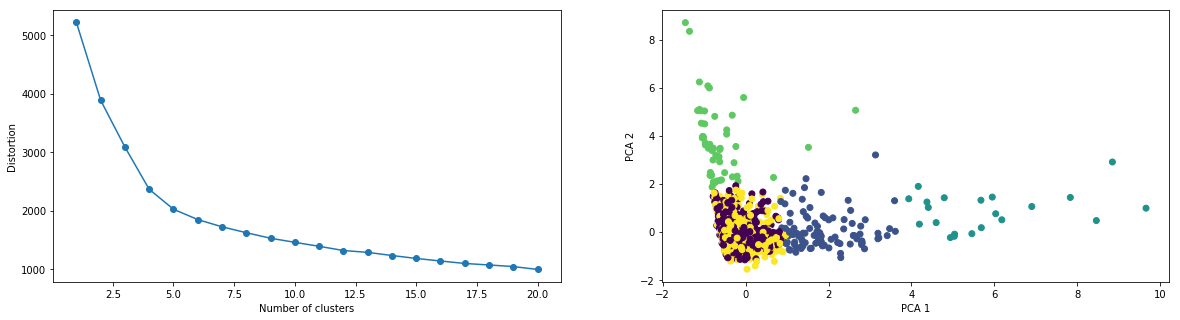

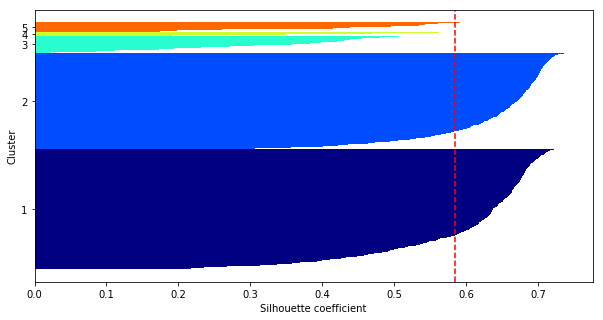

In [7]:
num_list = ['lineitem_quantity','lineitem_price','season', 'color_group','category']

kmeans_display(num_list, orders_trunc, n_clusters=5)

In [10]:
# cluster analysis

print('Avg price per item:',orders_trunc['lineitem_price'].mean())
print('Avg quantity purchased:',orders_trunc['lineitem_quantity'].mean())
# avg quantity purchased: 2,19 items
# avg item price: US$5.4

clustered = kmeans_model(num_list, orders_trunc, n_clusters=5)
clustered.groupby('cluster').mean()

#clustered.loc[clustered.cluster == 0]['shipping_company'].unique().shape
#clustered.loc[clustered.cluster == 1]['shipping_company'].unique().shape
#clustered.loc[clustered.cluster == 2]['shipping_company'].unique().shape
#clustered.loc[clustered.cluster == 3]['shipping_company'].unique().shape
#clustered.loc[clustered.cluster == 4]['shipping_company'].unique().shape

# cluster 0: 682 companies - average order and price
# cluster 1: 97 companies - above avg size, avg price
# cluster 2: 21 companies - big orders, average item price
# cluster 3: 56 companies - av size, high price
# cluster 4: 548 companies - average order and price

('Avg price per item:', 5.403094456451764)
('Avg quantity purchased:', 2.1936094398037267)


,index,lineitem_quantity,lineitem_price
cluster,,,
0,40007.091988,1.951258,5.298300
1,42132.735254,8.601738,5.829561
2,63510.456204,27.412409,5.702190
3,51341.778976,2.404313,18.919677
4,46902.479266,1.922035,5.376483


In [11]:
# save new dataframe
customers_cluster = clustered
customers_cluster.to_csv('customers_cluster.csv', sep=',')

In [12]:
# cluster 4:
# mostly earrings, necklace
# mostly gold, multi, grey, white
# mostly oct-dec, least in apr-jun

# cluster 0:
# mostly earrings and necklace
# mostly gold, white, multi, silver
# mostly apr-jun, least in oct-dec

clustered.loc[clustered.cluster == 4].groupby('season')['index'].count().sort_values(ascending=False)
clustered.loc[clustered.cluster == 4].groupby('category')['index'].count().sort_values(ascending=False)
clustered.loc[clustered.cluster == 4].groupby('color_group')['index'].count().sort_values(ascending=False)

color_group
other          12496
gold            4533
multi           3241
grey            3068
white           3005
silver          2815
cyan_blue       1564
pink_purple      755
brown            726
green            656
red              529
yellow           422
Name: index, dtype: int64

## 3. Decision Tree

- a decision tree can help understanding the custoer behavior
- however, a single decisiont tree does not produce reliable results and can only be seen as a supporting tool
- ensemble and boosting models would increase the reliability but sacrifices interpretability

In [20]:
# decision tree: encoding categorical columns

clustered.head()
#clustered_tree = clustered.loc[clustered['category'] == 'necklace']
clustered_tree = clustered.copy()

for column in clustered_tree:
    
    if clustered_tree[column].dtype == 'object':
        le = LabelEncoder()
        clustered_tree[column] = le.fit_transform(clustered_tree[column])
        #print(dict(zip(le.classes_, le.transform(le.classes_))))

#clustered_tree = clustered_tree.groupby('shipping_company').mean()

clustered_tree.head()

,index,shipping_company,lineitem_quantity,lineitem_price,season,color_group,category,cluster
0,0,1205,1,3.50,2,1,9,0
1,1,1205,1,3.25,2,1,9,0
2,2,1205,1,10.50,2,6,9,0
3,3,1205,1,9.75,2,0,7,0
4,4,1205,1,5.25,2,5,1,0


In [38]:
tree_data = clustered_tree

tree = DecisionTreeRegressor(max_depth=500, random_state=1, min_samples_split=5, min_samples_leaf=10)
tree.fit(tree_data[['lineitem_price','season','color_group','category']], tree_data['lineitem_quantity'])


print(np.mean(cross_val_score(tree, tree_data[['lineitem_price','season','color_group','category']], tree_data['lineitem_quantity'], cv=5)))
print('R^:',tree.score(tree_data[['lineitem_price','season','color_group','category']], tree_data['lineitem_quantity']))   



-0.11593084428858362
('R^:', 0.10199218806544597)


In [ ]:
# decision tree wo predict lineitem_quantity

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
tree_data = clustered_tree

tree = DecisionTreeRegressor(max_depth=4, random_state=1, min_samples_split=10, min_samples_leaf=10)
tree.fit(tree_data[['lineitem_price','season','color_group','category']], tree_data['lineitem_quantity'])
print(np.mean(cross_val_score(tree, tree_data[['lineitem_price','season','color_group','category']], tree_data['lineitem_quantity'], cv=5)))
print('R^:',tree.score(tree_data[['lineitem_price','season','color_group','category']], tree_data['lineitem_quantity']))  

#tree_train, tree_test = train_test_split(tree_data, test_size=0.3, random_state=1)
#tree.fit(tree_train[['lineitem_price','season','color_group','category']], tree_train['lineitem_quantity'])
#tree.predict(tree_test[['lineitem_price','season','color_group','category']])
#print('meanCV score:',np.mean(cross_val_score(tree, tree_train[['lineitem_price','season','color_group','category']], tree_train['lineitem_quantity'], cv=5)))
#print('R^:',tree.score(tree_test[['lineitem_price','season','color_group','category']], tree_test['lineitem_quantity']))


from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, filled=True,
                          rounded=True,
                          feature_names=['lineitem_price','season','color_group','category'],
                          out_file=None)

graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

## 4. Analysis of over- and underperforming products

- predicting future sales is not ideal due to sparse data availability
- to get a bigger picture of how the store is doing, the performance of product lines per area, season, etc can be tested
- trends are visualized and significance is tested with t-tests

In [49]:
orders_trunc['category'].unique()

array(['ring', 'necklace', 'bracelet', 'earrings', 'clothing',
       'accessories', 'handbag', 'miscellaneous', 'other', 'cosmetics'],
      dtype=object)

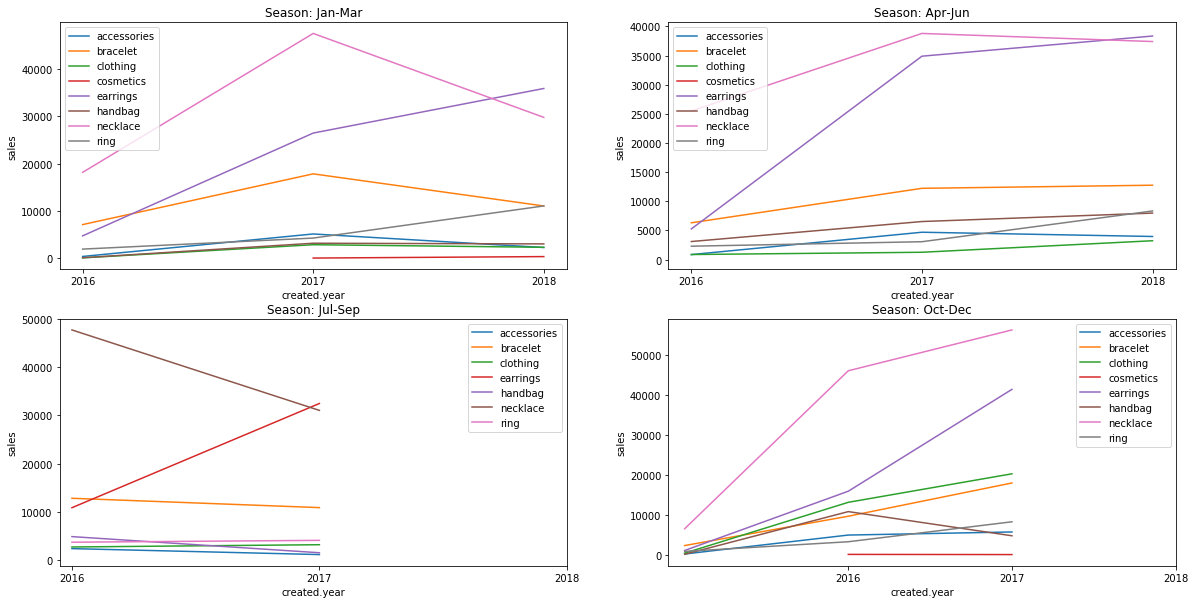

In [54]:
# Sales per category and season
plt.figure(facecolor='white', figsize=(20,10))

# create dataset for 1. quarter
main_1 = orders_trunc.loc[orders_trunc['category'].isin(['necklace', 'earrings','ring','bracelet','clothing',\
                                                        'accessories','handbag','cosmetics'])]
main_1 = main_1[['category','lineitem_total','season','created.year']]
main_1 = main_1.loc[main_1['season'] == 'jan-mar']
plt.subplot(221)
for index, group in main_1.groupby(['category']):
    group_agg = group.groupby(['created.year'])['lineitem_total'].sum()
    group_agg.plot(y='sales', title = 'Season: Jan-Mar',label=index, legend=True, xticks = (2016, 2017, 2018))
    plt.ylabel('sales')
    
# create dataset for 2. quarter    
main_2 = orders_trunc.loc[orders_trunc['category'].isin(['necklace', 'earrings','ring','bracelet','clothing',\
                                                        'accessories','handbag','cosmetics'])]
main_2 = main_2[['category','lineitem_total','season','created.year']]
main_2 = main_2.loc[main_2['season'] == 'apr-jun']
plt.subplot(222)
for index, group in main_2.groupby(['category']):
    group_agg = group.groupby(['created.year'])['lineitem_total'].sum()
    group_agg.plot(y='sales', title = 'Season: Apr-Jun',label=index, legend=True, xticks = (2016, 2017, 2018))
    plt.ylabel('sales')
   
# create dataset for 3. quarter    
main_3 = orders_trunc.loc[orders_trunc['category'].isin(['necklace', 'earrings','ring','bracelet','clothing',\
                                                        'accessories','handbag','cosmetics'])]
main_3 = main_3[['category','lineitem_total','season','created.year']].loc[main_3['created.year'] != 2018]
main_3 = main_3.loc[main_3['season'] == 'jul-sep']
plt.subplot(223)
for index, group in main_3.groupby(['category']):
    group_agg = group.groupby(['created.year'])['lineitem_total'].sum()
    group_agg.plot(y='sales', title = 'Season: Jul-Sep',label=index, legend=True, xticks = (2016, 2017, 2018))
    plt.ylabel('sales')
    

# create dataset for 4. quarter    
main_4 = orders_trunc.loc[orders_trunc['category'].isin(['necklace', 'earrings','ring','bracelet','clothing',\
                                                        'accessories','handbag','cosmetics'])]
main_4 = main_4[['category','lineitem_total','season','created.year']]
main_4 = main_4.loc[main_4['season'] == 'oct-dec']
plt.subplot(224)
for index, group in main_4.groupby(['category']):
    group_agg = group.groupby(['created.year'])['lineitem_total'].sum()
    group_agg.plot(y='sales', title = 'Season: Oct-Dec',label=index, legend=True, xticks = (2016, 2017, 2018))
    plt.ylabel('sales')

- All categories gain popularity end of year: gifts for holidays
- Earrings and rings gain popularity across season, but rings are least profitable
- Necklace only in winter months: gifts for holidays?
- Bracelets are consistent, no real growth in sales
- cosmetics only sold between Jul and Sep
- clothing mostly sold in winter months

In [ ]:
# specify features to be grouped for stats
cat_list = ['shipping_province','color_group', 'category', 'created.month', 'shape', 'material']

#specifiy subgroups or total dataset
#orders_earrings = orders_trunc.loc[orders_trunc.category == 'earrings']

# for all columns specified to get an overview
for i in cat_list:
    print(orders_trunc.groupby(i)[['lineitem_quantity', 'lineitem_total']]
          .agg({'avg': 'mean', 'sum': 'sum'})
          .reset_index())

#compare with total mean
orders_trunc['lineitem_total'].mean()

In [49]:
# overperforming continents
by_continent = stats_comparison('shipping_continent', orders_trunc)
by_continent.loc[by_continent.significant == 1].sort_values(by='shipping_continent')

,shipping_continent,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant
5,us,926289.19,11.273251,11.387867,974744.48,48455.29,-215.500941,20.672311,10.969948,1.0,1


In [65]:
# overperforming states
by_state = stats_comparison('shipping_province', orders_trunc)
by_state.loc[by_state.significant == 1].sort_values(by='shipping_province')

,shipping_province,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant
25,mn,35605.25,26.413390,11.387867,974744.48,939139.23,-1.001263,20.672311,1.326153,0.907606,1
40,ok,1227.90,33.186486,11.387867,974744.48,973516.58,-0.041725,20.672311,1.607378,0.946014,1
57,wko,120.00,120.000000,11.387867,974744.48,974624.48,-0.014642,20.672311,5.805574,1.000000,1


In [42]:
# overperforming cities
by_city = stats_comparison('shipping_city', orders_trunc)
by_city.loc[by_city.significant == 1].sort_values(by='sub_average_$', ascending=False)

,shipping_city,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant
279,groveport,8550.00,777.272727,11.387867,974744.48,966194.48,-6.878069,20.672311,37.932420,1.000000,1
293,hartsville,258.75,258.750000,11.387867,974744.48,974485.73,-0.068571,20.672311,12.520060,1.000000,1
616,point roberts,2309.25,230.925000,11.387867,974744.48,972435.23,-0.548246,20.672311,11.197260,1.000000,1
151,conshohocken,855.00,171.000000,11.387867,974744.48,973889.48,-0.149992,20.672311,8.279190,1.000000,1
28,avon,648.00,162.000000,11.387867,974744.48,974096.48,-0.107634,20.672311,7.841776,1.000000,1
280,guaynabo,1364.25,136.425000,11.387867,974744.48,973380.23,-0.191074,20.672311,6.608650,1.000000,1
614,point pleasant beach,250.00,125.000000,11.387867,974744.48,974494.48,-0.031935,20.672311,6.048280,1.000000,1
776,"tamahere, hamilton",120.00,120.000000,11.387867,974744.48,974624.48,-0.014642,20.672311,5.805574,1.000000,1
462,minneapolis,25418.41,108.163447,11.387867,974744.48,949326.07,-2.895963,20.672311,5.372375,1.000000,1
16,ardmore,105.00,105.000000,11.387867,974744.48,974639.48,-0.011179,20.672311,5.079799,1.000000,1


In [66]:
#overperforming colors
by_color = stats_comparison('color1', orders_trunc)
by_color.loc[by_color.significant == 1].sort_values(by='color1')

,color1,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant
5,beige/pink,140.25,28.050000,11.387867,974744.48,974604.23,-0.003903,20.672311,1.357076,0.912622,1
10,black-ivory,42.50,42.500000,11.387867,974744.48,974701.98,-0.001720,20.672311,2.055973,0.980107,1
12,black-pearl,229.50,57.375000,11.387867,974744.48,974514.98,-0.013379,20.672311,2.776099,0.997249,1
14,black-silver,152.25,50.750000,11.387867,974744.48,974592.23,-0.007795,20.672311,2.455352,0.992963,1
25,camouflage,569.75,29.986842,11.387867,974744.48,974174.73,-0.017405,20.672311,1.451422,0.926669,1
99,red-pink,135.00,135.000000,11.387867,974744.48,974609.48,-0.018567,20.672311,6.531373,1.000000,1
117,tortoise-1,28.00,28.000000,11.387867,974744.48,974716.48,-0.000671,20.672311,1.354501,0.912212,1
124,watercolor,454.92,34.993846,11.387867,974744.48,974289.56,-0.016206,20.672311,1.693572,0.954827,1


In [67]:
# overperforming material
by_material = stats_comparison('material', orders_trunc)
by_material.loc[by_material.significant == 1].sort_values(by='material')

,material,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant
6,bamboo,4483.00,52.741176,11.387867,974744.48,970261.48,-0.243552,20.672311,2.563077,0.994813,1
14,fur,12114.05,29.985272,11.387867,974744.48,962630.43,-0.377210,20.672311,1.468751,0.929050,1
29,plaid,7135.00,37.161458,11.387867,974744.48,967609.48,-0.273889,20.672311,1.810893,0.964921,1
43,studded,282.00,28.200000,11.387867,974744.48,974462.48,-0.008028,20.672311,1.364532,0.913800,1
49,woven,890.00,37.083333,11.387867,974744.48,973854.48,-0.033757,20.672311,1.795498,0.963713,1


In [68]:
#overperforming category
by_category = stats_comparison('category', orders_trunc)
by_category.loc[by_category.significant == 1].sort_values(by='category')

,category,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant
5,handbag,48033.75,39.566516,11.387867,974744.48,926710.73,-2.050692,20.672311,2.013186,0.977952,1


In [54]:
# overperforming customers: most belong to cluster 1 (above avg order size, average price)
by_customer = stats_comparison('shipping_company', orders_trunc)
by_customer_overperform = by_customer.loc[by_customer.significant == 1].sort_values(by='shipping_company')

customer_cluster_overperform = by_customer_overperform.merge(clustered, on = 'shipping_company', how='left')
print(customer_cluster_overperform.groupby('cluster').count()['index'])

customer_cluster_overperform.sample(10)

cluster
0.0     604
1.0    1925
2.0     274
3.0     218
4.0     581
Name: index, dtype: int64


,shipping_company,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant,index,lineitem_quantity,lineitem_price,season,color_group,category,cluster
1272,karma and luck,422.75,52.843750,11.387867,974744.48,974321.73,-0.022795,20.672311,2.557360,0.994727,1,83514.0,10.0,7.50,jan-mar,other,bracelet,1.0
3071,tiffany's boutique (magic show),1012.28,56.237778,11.387867,974744.48,973732.20,-0.058331,20.672311,2.723261,0.996768,1,57568.0,12.0,3.00,jan-mar,multi,bracelet,1.0
723,city mall david,5570.00,46.033058,11.387867,974744.48,969174.48,-0.264426,20.672311,2.239589,0.987441,1,4549.0,12.0,4.25,apr-jun,silver,accessories,1.0
2220,mam creaciÓnes ltda,10995.85,56.973316,11.387867,974744.48,963748.63,-0.649900,20.672311,2.787459,0.997344,1,34724.0,15.0,7.00,oct-dec,cyan_blue,necklace,1.0
1799,lilac bijoux,3567.00,36.773196,11.387867,974744.48,971177.48,-0.134929,20.672311,1.785389,0.962901,1,85488.0,4.0,7.25,oct-dec,white,ring,4.0
1872,lilyhockcreations c/o lerner,3826.90,45.022353,11.387867,974744.48,970917.58,-0.177323,20.672311,2.186484,0.985610,1,48657.0,1.0,24.75,apr-jun,cyan_blue,necklace,0.0
3228,u.s. jewelry house of florida,4832.50,56.191860,11.387867,974744.48,969911.98,-0.279837,20.672311,2.731755,0.996850,1,65005.0,3.0,22.00,oct-dec,gold,handbag,3.0
593,chiymarie accessories,66.25,33.125000,11.387867,974744.48,974678.23,-0.002118,20.672311,1.602487,0.945476,1,22105.0,3.0,19.75,jan-mar,grey,handbag,0.0
983,grace,4593.50,31.248299,11.387867,974744.48,970150.98,-0.147822,20.672311,1.518752,0.935588,1,8868.0,6.0,4.50,apr-jun,yellow,cosmetics,1.0
2877,sparklesglllc,1581.00,47.909091,11.387867,974744.48,973163.48,-0.077700,20.672311,2.321307,0.989865,1,82461.0,6.0,4.50,jan-mar,multi,necklace,1.0


In [53]:
# average customers
by_customer = stats_comparison('shipping_company', orders_trunc)
by_customer_average = by_customer.loc[by_customer.significant == 0].sort_values(by='shipping_company')

#merge to original dataset only containing average companies: : most belong to cluster 0 and 4
customer_cluster_average = by_customer_average.merge(clustered, on = 'shipping_company', how='left')
print(customer_cluster_average.groupby('cluster').count()['index'])

customer_cluster_average.sample(10)

cluster
0    48348
1      262
3      153
4    33229
Name: index, dtype: int64


,shipping_company,sub_sum_$,sub_average_$,overall_average_$,overall_sum_$,rest_sum_$,rest_average_$,std,z_score,prob,significant,index,lineitem_quantity,lineitem_price,season,color_group,category,cluster
17495,crimzonrose,5689.15,9.265717,11.387867,974744.48,969055.33,-0.054264,20.672311,0.450844,0.673949,0,74429,1,2.50,jul-sep,yellow,earrings,0
51762,nicole miller,851.44,8.869167,11.387867,974744.48,973893.04,-0.007621,20.672311,0.429405,0.666186,0,56528,1,3.00,jan-mar,other,necklace,0
21239,dmonaco designs,1399.10,5.465234,11.387867,974744.48,973345.38,-0.007723,20.672311,0.264748,0.604398,0,1485,1,6.00,jul-sep,white,necklace,4
59718,revivals boutique,330.23,11.387241,11.387867,974744.48,974414.25,-0.003726,20.672311,0.551025,0.709192,0,48014,1,9.75,apr-jun,other,necklace,0
32498,hershey farm gift shop,1865.47,12.865310,11.387867,974744.48,972879.01,-0.024536,20.672311,0.623532,0.733532,0,13309,3,2.75,apr-jun,gold,necklace,0
2298,accents,1958.53,7.802908,11.387867,974744.48,972785.95,-0.015576,20.672311,0.378210,0.647363,0,47011,3,2.00,apr-jun,gold,earrings,0
41560,lace boutique inc.,425.00,6.538462,11.387867,974744.48,974319.48,-0.002719,20.672311,0.316422,0.624159,0,73290,1,2.25,jul-sep,other,bracelet,4
30941,"golden rule, inc",2324.88,13.061124,11.387867,974744.48,972419.60,-0.031093,20.672311,0.633321,0.736738,0,78961,2,4.00,apr-jun,multi,earrings,0
78934,violet boutique,6269.25,4.523268,11.387867,974744.48,968475.23,-0.029147,20.672311,0.220218,0.587149,0,22895,2,3.75,jan-mar,white,earrings,0
42840,lettie gooch enterprises llc,263.25,4.875000,11.387867,974744.48,974481.23,-0.001184,20.672311,0.235880,0.593237,0,43068,1,2.75,jul-sep,gold,earrings,4


### Supplementary: example plots and analysis

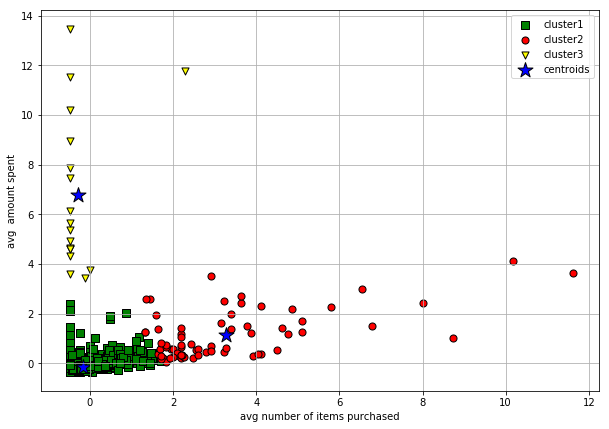

In [119]:
# example plot with 3 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=0)
test_km = km.fit_predict(test)


plt.figure(figsize = (10,7), facecolor='w' )

plt.scatter(test.iloc[test_km == 0, 0],
           test.iloc[test_km == 0,1],
           s=50, c='green', marker='s', edgecolor='black',label = 'cluster1')

plt.scatter(test.iloc[test_km == 1, 0],
           test.iloc[test_km == 1,1],
           s=50, c='red', marker='o', edgecolor='black',label = 'cluster2')

plt.scatter(test.iloc[test_km == 2, 0],
           test.iloc[test_km == 2,1],
           s=50, c='yellow', marker='v', edgecolor='black',label = 'cluster3')

plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=250, marker='*', c='blue',edgecolor='black', label = 'centroids')

plt.legend(scatterpoints=1)
plt.grid()

plt.ylabel('avg  amount spent')
plt.xlabel('avg number of items purchased')

plt.show()

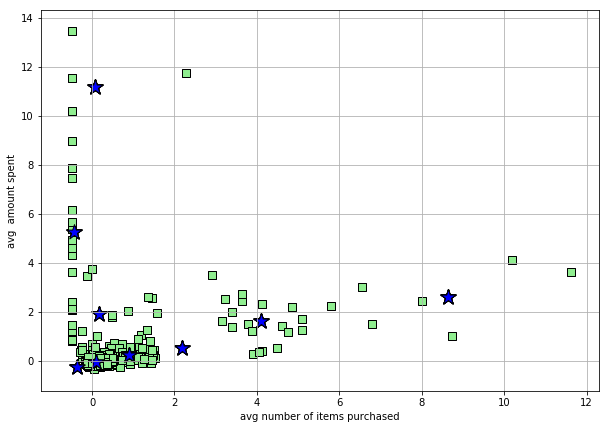

In [121]:
# plot for 9 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=9, random_state=0)
test_km = km.fit_predict(test)

plt.figure(figsize = (10,7), facecolor='w' )

for i in range(1,8):
    
    plt.scatter(test.iloc[test_km == i, 0],
               test.iloc[test_km == i,1],
               s=50, c='lightgreen', marker='s', edgecolor='black',)
    
    plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=250, marker='*', c='blue',edgecolor='black', label = 'centroids')

plt.grid()
    
plt.ylabel('avg  amount spent')
plt.xlabel('avg number of items purchased')

plt.show()

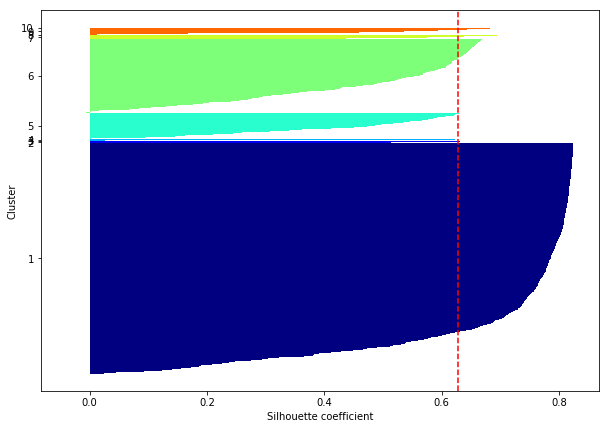

In [146]:
## silhouette plots
from sklearn.metrics import silhouette_samples
from matplotlib import cm
plt.figure(figsize = (10,7), facecolor='w' )

km = KMeans(n_clusters=10, random_state=0)
test_km = km.fit_predict(test)

cluster_labels = np.unique(test_km)
n_cluster = cluster_labels.shape[0]

sil_vals = silhouette_samples(test, test_km, metric = 'euclidean')

y_ax_lower, y_ax_upper = 0, 0

yticks = []

for i, c in enumerate(cluster_labels):
    c_sil_vals = sil_vals[test_km == c]
    c_sil_vals.sort()
    
    y_ax_upper += len(c_sil_vals)
    color = cm.jet(float(i)/ n_cluster)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_sil_vals,
            height=1.0,
            edgecolor = 'none',
            color=color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    
    y_ax_lower += len(c_sil_vals)
    
sil_avg = np.mean(sil_vals)
plt.axvline(sil_avg,
           color='red',
           linestyle='--')

plt.yticks(yticks, cluster_labels +1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()